<a href="https://colab.research.google.com/github/Maraudier/SquadColaChat/blob/Maraudier-testing-1/CoLABERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [0]:
import torch

if torch.cuda.is_available():    

    device = torch.device("cuda")
    print('%d GPU(s) available.' % torch.cuda.device_count())
    print('Using GPU:', torch.cuda.get_device_name(0))
else:
    print('Only CPU available')
    device = torch.device("cpu")

1 GPU(s) available.
Using GPU: Tesla T4


In [0]:
!pip install transformers

In [0]:
!pip install wget

In [0]:
import wget
import os
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'
if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

In [0]:
if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

In [0]:
import pandas as pd
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', 
                 header=None, 
                 names=['sentence_source', 
                        'label', 
                        'label_notes', 
                        'sentence'])
sentences = df.sentence.values
labels = df.label.values
#Visual Education
print("Training samples: {:,}\n".format(df.shape[0]))
print("Example of label 0 = Unacceptable sentances ")
display(df.loc[df.label == 0].sample(3)[['sentence', 'label']])
print("\nExample of label 1 = Acceptable sentances")
display(df.loc[df.label == 1].sample(3)[['sentence', 'label']])

Training samples: 8,551

Example of label 0 = Unacceptable sentances 


,sentence,label
4021,The foxes seem compatible for the chickens.,0
4099,Why don't you leaving me concentrate on my work?,0
20,The professor talked us.,0



Example of label 1 = Acceptable sentances


,sentence,label
15,Bill broke the bathtub into pieces.,1
2229,This machine records well.,1
6401,"Every student in Mary's class, by virtue of be...",1


In [0]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [0]:
input_ids = []

# For every sentence... Define sent from SQAUD Dataset
#df.loc[df.label == 0].sample(5)[['sentence', 'label']]
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  Our friends won't buy this analysis, let alone the next one we propose.
Token IDs: [101, 2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012, 102]


In [0]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  47


Given that, let's choose MAX_LEN = 64 and apply the padding.

In [0]:
from keras.preprocessing.sequence import pad_sequences
MAX_LEN = 50

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')

print(input_ids[0])


Padding/truncating all sentences to 50 values...

Padding token: "[PAD]", ID: 0

Done.
[  101  2256  2814  2180  1005  1056  4965  2023  4106  1010  2292  2894
  1996  2279  2028  2057 16599  1012   102     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0]


In [0]:
attention_masks = []

for sent in input_ids:
    att_mask = [int(token_id > 0) for token_id in sent]
    attention_masks.append(att_mask)

print(attention_masks[0])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [0]:
from sklearn.model_selection import train_test_split
#80/20
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.2)

In [0]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [0]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 2, 
    output_attentions = False, 
    output_hidden_states = False)

model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

# print('The BERT model has {:} different named parameters.\n'.format(len(params)))

# print('==== Embedding Layer ====\n')

# for p in params[0:5]:
#     print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# print('\n==== First Transformer ====\n')

# for p in params[5:21]:
#     print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

# print('\n==== Output Layer ====\n')

# for p in params[-4:]:
#     print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

In [0]:
optimizer = AdamW(model.parameters(),
                  lr = 3e-5,
                  eps = 1e-8)

In [0]:
from transformers import get_linear_schedule_with_warmup
epochs = 2

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [0]:
import numpy as np

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [0]:
import random

seed_val = 38

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

loss_values = []

for epoch_i in range(0, epochs):
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    t0 = time.time()
    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)
    t0 = time.time()

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")


    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 2 ========
Training...
  Batch    40  of    428.    Elapsed: 0:00:07.
  Batch    80  of    428.    Elapsed: 0:00:14.
  Batch   120  of    428.    Elapsed: 0:00:21.
  Batch   160  of    428.    Elapsed: 0:00:28.
  Batch   200  of    428.    Elapsed: 0:00:34.
  Batch   240  of    428.    Elapsed: 0:00:41.
  Batch   280  of    428.    Elapsed: 0:00:49.
  Batch   320  of    428.    Elapsed: 0:00:56.
  Batch   360  of    428.    Elapsed: 0:01:03.
  Batch   400  of    428.    Elapsed: 0:01:10.

  Average training loss: 0.50
  Training epcoh took: 0:00:00

Running Validation...
  Accuracy: 0.80
  Validation took: 0:00:06

======== Epoch 2 / 2 ========
Training...
  Batch    40  of    428.    Elapsed: 0:00:07.
  Batch    80  of    428.    Elapsed: 0:00:15.
  Batch   120  of    428.    Elapsed: 0:00:22.
  Batch   160  of    428.    Elapsed: 0:00:29.
  Batch   200  of    428.    Elapsed: 0:00:37.
  Batch   240  of    428.    Elapsed: 0:00:44.
  Batch   280  of    428.    Elap

Let's take a look at our training loss over all batches:

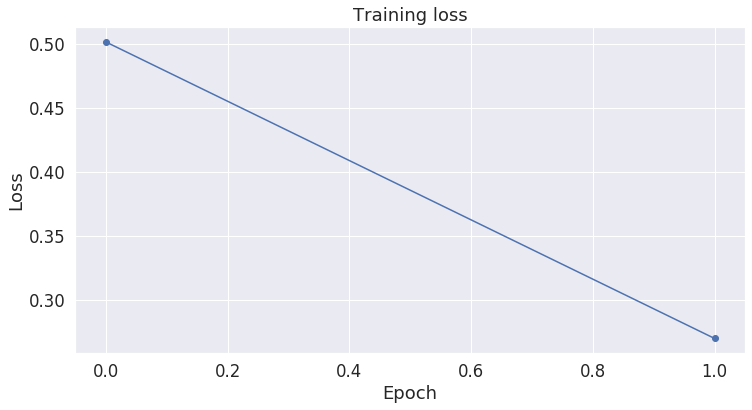

In [0]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [0]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentence.values
labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 516



In [0]:
print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # print(b_input_ids.shape)
  
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  # print(type(logits))

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  # print(logits)
  # print(label_ids)
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 516 test sentences...
[[-1.538613    0.79492474]
 [-1.9691813   1.2737497 ]
 [-2.0917194   1.5434027 ]
 [-2.2420774   1.5707169 ]
 [-1.9667499   1.1803105 ]
 [-2.4949188   1.962707  ]
 [-1.5878145   0.920532  ]
 [-2.0202684   1.4587833 ]
 [-2.592879    2.1435487 ]
 [-2.1405864   1.7431492 ]
 [-1.7049026   1.0377374 ]
 [ 0.03699965 -0.10038966]
 [-2.1580524   1.2887192 ]
 [-0.8708725   0.1979861 ]
 [-1.9869808   1.340426  ]
 [-1.746131    0.8906261 ]
 [-2.0602882   1.3783175 ]
 [ 1.5511489  -1.3508545 ]
 [-1.7716842   1.3031995 ]
 [-1.1232085   1.0699772 ]
 [-1.7716842   1.3031995 ]
 [-1.5867031   0.9369427 ]
 [-1.8288385   1.3004646 ]
 [-2.1540415   1.539912  ]
 [-1.6933258   0.9525095 ]
 [-1.8595952   1.1120687 ]
 [-1.9480929   1.5139014 ]
 [-1.9154068   1.3498212 ]
 [-2.2230394   1.5007023 ]
 [-1.6633259   1.0462829 ]
 [-2.001639    1.3397664 ]
 [-1.5236704   0.8351253 ]]
[1 1 1 1 1 1 0 0 1 1 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 1 1 1 1 1 1 1]
[[-0.43420994  0.3225862 

In [0]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 354 of 516 (68.60%)


In [0]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


The final score will be based on the entire test set, but let's take a look at the scores on the individual batches to get a sense of the variability in the metric between batches. 

Each batch has 32 sentences in it, except the last batch which has only (516 % 32) = 4 test sentences in it.


In [0]:
matthews_set

[0.049286405809014416,
 -0.21684543705982773,
 0.4040950971038548,
 0.11365840154561273,
 0.32328707534629597,
 0.6777932975034471,
 0.6831300510639732,
 0.47519096331149147,
 0.8320502943378436,
 0.8126375006351424,
 0.6777749493656265,
 0.7624437362098716,
 0.936441710371274,
 0.647150228929434,
 0.4622501635210242,
 0.47306844125299624,
 0.0]

In [0]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Matthews correlation coefficient is measure of the quality of binary and multiclass classifications: %.3f' % mcc)


Matthews correlation coefficient is measure of the quality of binary and multiclass classifications: 0.531


In [0]:
def predict(text, model):
  #input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", value=0, truncating="post", padding="post")
  #masks

SyntaxError: ignored

In [0]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


In [0]:
torch.save(model, "Colabertmodel.h5")

Let's check out the file sizes, out of curiosity.

In [0]:
!ls -l --block-size=K ./model_save/

The largest file is the model weights, at around 418 megabytes.

In [0]:
!ls -l --block-size=M ./model_save/pytorch_model.h5

To save your model across Colab Notebook sessions, download it to your local machine, or ideally copy it to your Google Drive.

In [0]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ "./Revature"